# Welcome to Your Cresta Project Interview 🙂

## Background

Cresta builds AI products that augments teams by reducing their cognitive workload and by doing repetitive tasks for them. One of Cresta's products is used by agents chatting with a website's customers. 

Agents often have to handle multiple chats at the same time during rush hours. This makes the task of satisfying the customers' needs and closing the sale considerably harder since the agents have to divide their time and attention across multiple visitors. 

## A mini-project
Let’s say Cresta decides to start its own telecom services and wants to use an intelligent assistant for making all its agents experts from day one. For achieving this, the first step we decide to do is dig through some of the chats which agents have had and find out insights like why a customer is chatting in, how many times a sale is being made, what agent behaviors are leading to that and any other interesting patterns which can help us make the best intelligent assistant.

## Dataset
You are given raw chat transcripts(`project_chats.json`) each with a list of messages. Each message has a time at which message was sent, speaker role (ex. agent, visitor or system) and text of the message

Note: You will need to upload the data file provided in the google drive folder to this collab notebook.

**Example chat 1**:
```
agent: Good evening! Thank you for visiting Cresta Sales Chat! My name is 
 Alex. It will be my pleasure to assist you with adding new services or upgrading existing services today!
agent: Do you currently have any services with us?
visitor: I would like to upgrade my service
visitor: Yes
agent: Wonderful! I am happy to assist you with upgrading your services!
visitor: Great
agent: From the shop page you are on go into your View and Upgrade options to upgrade services online.
agent: What services are you upgrading this evening?
visitor: I would like to upgrade tv services
```

**Example chat 2**:
```
agent: Good evening! Thank you for visiting Cresta Sales Chat! My name is 
 Alex. It will be my pleasure to assist you with adding new services or upgrading existing services today!
agent: Do you currently have any services with us?
visitor: I would like to upgrade my service
```

## Questions to Answer
When analyzing the conversations, you should be looking to find insights and statistics to support answering the following questions:
  1. Why are customers chatting in and whats the distribution across the different reasons? For example, they could be chatting into buy a new product or to get support on an existing service. 
  2. What types of products are customers trying to buy or upgrade?
  3. Whats the percentage for a sale being made across all chats? Is it consistent across different products? (hint: look for messages indicating a confirmation of the sale)
  4. When a sale is made, are there any trends from the agent messages leading up to the sale?
  5. Suprise us! What's something else interesting from the conversations that you were able to find?


## Deliverables
1. A report (pdf/google doc: assume this would be something that you would present externally to a customer!) documenting your findings from the chat analysis. 

2. The code you used for doing the chat analysis as part of this collab notebook. The notebook is setup in a way so that you can strcuture the code based on the questions above but feel free to modify it as you see fit.

We will be evaluating your deliverables based on:
 * The report itself: is it an artifact that could be shared externally? Is it professional? Are the results clearly communicated? Can someone with little context understand what you are answering?
 * The analysis: Is it comprehensive? Did you account for edge cases and get creative with how to answer the questions? Is it scalable to 1,000 chats? What about 100,000? Is it stastically significant? Would you trust that the results are accurate and could be depended on?
 * The code: Is it readable? Would it be reusable if you had to do this analysis for another group? 

Our expectation is the project takes around 4 hours to complete. 

If you have any questions at all during the project, please don't hesitate to reach out to us! 

# Dependencies

We have most python packages prepared for you. 

In [1]:
# numpy, scipy, pandas
import numpy as np, scipy, pandas as pd

# pytorch
#import torch

# tensorflow 0.12.0
#import tensorflow as tf

import sys
import nltk
import re
nltk.download(['punkt', 'wordnet'])
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.metrics import classification_report, accuracy_score


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aisuluomar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aisuluomar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

You can install any package with !pip install.

## Load Data
Chats are stored as a list of json objects in the file ```project_chats.json```

In [125]:
df_raw = pd.read_json('project_chats.json')
df2 = df['messages'].apply(pd.Series)
df2['message_board_num'] = df2.index

In [834]:
#This is the raw data
df_raw.head()

,messages
0,"[{'text': 'I want to ask for a favor.', 'speak..."
1,[{'text': 'Chat Recording: Bot: Hello! I am Ol...
2,"[{'text': 'Fast connection configuration', 'sp..."
3,"[{'text': 'I want to ask for a favor.', 'speak..."
4,[{'text': 'How can I complete my self-activati...


In [117]:
new_df = pd.DataFrame()
#Appending every message as a separate row in data frame
for i in range(99):
    new_df = new_df.append(df2.loc[i].apply(pd.Series), ignore_index=True)

In [119]:
new_df.rename({0:'chat_number'}, axis=1, inplace=True)

In [120]:
#Number of separate chats
list_boards = list(new_df.index[~new_df['chat_number'].isnull()])

In [129]:
#Adding chat number to every row 
for num in range(len(list_boards)-1):
    new_df['chat_number'][list_boards[num]:list_boards[num+1]] = f'message_board_{num+1}'

In [133]:
new_df['chat_number'][0:list_boards[0]] = f'message_board_0'
new_df['chat_number'][list_boards[-1]:] = f'message_board_98'


In [136]:
new_df.dropna(subset=['text'],inplace=True)

In [833]:
#Data after transformation
new_df.head()

,chat_number,speaker_role,text,timestamp,time
0,message_board_0,visitor,I want to ask for a favor.,1.602636e+09,NaT
1,message_board_0,agent,"Okay, just a quick question to clarify what yo...",1.602636e+09,NaT
2,message_board_0,visitor,I'm not Cresta's client yet.,1.602636e+09,NaT
3,message_board_0,agent,Give me a moment while I find a live agent for...,1.602636e+09,NaT
4,message_board_0,agent,"Hi, my name is Jeri and I'm happy to help you.",1.602636e+09,NaT


## Analysis

In [879]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

byChat = new_df.groupby('chat_number')['text'].count().sort_values(ascending=False)
print(f'Number of chats: {len(byChat)}')
print(f'Highest number of messages in a chat: {byChat.max()}')
print(f'Lowest number of messages in a chat: {byChat.min()}')
print(f'Average number of messages in a chat: {round(byChat.mean())}')


Number of chats: 99
Highest number of messages in a chat: 169
Lowest number of messages in a chat: 2
Average number of messages in a chat: 40


### Why and how often are customers chatting in? For example, they could be chatting into buy a new product or to get support on an existing service. 

In [986]:
#Selecting client chats 
client_df = new_df[new_df['speaker_role'] == 'visitor']

In [987]:
import re 
import string
from nltk.corpus import stopwords

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)

    #deleting stop_words
    stop_words = stopwords.words('english')
    stop_words.extend(['n','s','i','xxx','this', 'like', 'so', 'and', 'hey', 'for', 'hi', 'that', 'on', 'in'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]

    return ' '.join(tokens)
                    
                    
#alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
client_df['text'] = client_df['text'].apply(lambda x: tokenize_me(x))
client_df['text'] = client_df['text'].map(punc_lower)

In [988]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Apro
def normalise_string(input_str):
    bad_words = {'so','like','very','more',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(parsed.normal_form)
    return ' '.join(norm_words_list)
client_df['text']  = client_df['text'].apply(lambda x: normalise_string(x))

/opt/anaconda3/lib/python3.7/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/opt/anaconda3/lib/python3.7/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/opt/anaconda3/lib/python3.7/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/opt/anaconda3/lib/python3.7/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, def

In [989]:
def filter_string(input_str):
    bad_words = {'so','like','very','more',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(word)
    return ' '.join(norm_words_list)

client_df['text']  = client_df['text'].apply(lambda x: filter_string(x))
client_df['text'].head()

0                                     i want ask favor
2                              i m cresta s client yet
5                                                hello
6    i wondering name bill one roommates could take...
8                                             samantha
Name: text, dtype: object

In [836]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

def get_words_by_threshold_report(text_series):
    vectorizer = CountVectorizer()

    counts = vectorizer.fit_transform(text_series)
    corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

    print('Words in the library: {}\n'.format(counts.shape[1]))
    print('Top 20 words: ', Counter(' '.join(text_series.values).split()).most_common(20), '\n')

    print('Words with higher occurrence:', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-40:][::-1]])
    print()
    print('Words with lower occurrence: ', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])
    return counts, vectorizer, corpus_id2word

def get_lda_model(counts, corpus_id2word, num_topics=10, alpha_value=0.1, var_iter=50, passes=50):
    gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
    t_start = time.time()
    lda = gensim.models.LdaModel(
        corpus=gensim_corpus,
        passes=passes,
        num_topics=num_topics,
        alpha=[alpha_value] * num_topics,
        iterations=var_iter,
        id2word=corpus_id2word,
        eval_every=0,
        random_state=42
    )
    current_score = lda.bound(gensim_corpus)
    time_ellapsed = int(time.time() - t_start)

    print('ELBO = {1:.4f}, time: {2} seconds'.format(
        alpha_value, current_score, time_ellapsed))
    
    gamma, _ = lda.inference(gensim_corpus)
    gamma = gamma / gamma.sum(1).reshape(-1, 1)
    
    return lda, gamma

def build_topic_words_report(lda, top_words_num=25, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    topic_space = max(map(len, topic_names)) + 2
    
    if topic_space==2:
        for topic_index in range(lda.num_topics):
            print('{0} topic: {1}'.format(
                topic_index, ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        return
    
    for topic_index in range(lda.num_topics):
        print('{0} topic :{1: ^{2}}: {3}'.format(
            topic_index, topic_names[topic_index], topic_space,
            ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        
def build_topic_subjects_report(lda, gamma, text_series, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    for topic_index in range(lda.num_topics):
        print('Topic {0} - {1}'.format(topic_index, topic_names[topic_index]))
        best_doc_indexes = gamma[:, topic_index].argsort()[-10:][::-1]
        
        subjects_with_proba = []
        for person_count, doc in enumerate(best_doc_indexes):
            if gamma[doc, topic_index] > 0.01 or person_count<3:
                subjects_with_proba.append('{0} - {1:.1%}'.format(text_series.index[doc], gamma[doc, topic_index]))
        print(', '.join(subjects_with_proba), '\n')


In [837]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(client_df['text'])


Words in the library: 1654

Top 20 words:  [('right', 165), ('internet', 162), ('thank', 120), ('service', 102), ('want', 96), ('cresta', 95), ('need', 92), ('modem', 73), ('yes', 61), ('new', 58), ('ask', 55), ('account', 54), ('one', 53), ('update', 52), ('services', 51), ('get', 51), ('plan', 48), ('would', 46), ('okay', 42), ('month', 42)] 

Words with higher occurrence: ['right', 'internet', 'thank', 'service', 'want', 'cresta', 'need', 'modem', 'yes', 'new', 'ask', 'account', 'one', 'update', 'services', 'get', 'plan', 'would', 'month', 'okay', 'cable', 'know', 'help', 'ca', 'add', 'tv', 'agent', 'much', 'looking', 'see', 'think', 'move', 'favor', 'thanks', 'bot', 'going', 'number', 'speed', 'yet', 'time']

Words with lower occurrence:  ['0a', 'mi424wr', 'michele', 'michelson', 'might', 'min', 'minicajas', 'minimize', 'minimum', 'mira', 'misokie', 'missed', 'missing', 'missokia', 'mistakes', 'method', 'modalities', 'molinero', 'mom', 'monitored']


In [896]:
lda_norm, gamma_norm = get_lda_model(counts, corpus_id2word, num_topics=5)

ELBO = -51010.2259, time: 31 seconds


In [892]:
l = []
for i in range(5,12):
    l.append(get_lda_model(counts, corpus_id2word, num_topics=i))

ELBO = -51010.2259, time: 26 seconds
ELBO = -51235.6893, time: 25 seconds
ELBO = -51433.5014, time: 26 seconds
ELBO = -51812.2970, time: 26 seconds
ELBO = -51927.6913, time: 28 seconds
ELBO = -52185.1094, time: 27 seconds
ELBO = -52593.2741, time: 40 seconds


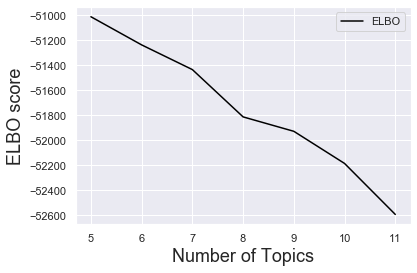

In [1061]:
plt.plot([5,6,7,8,9,10,11],[-51010.2259,-51235.6893,-51433.5014,-51812.2970,-51927.6913,-52185.1094,-52593.2741], label='ELBO',color='black')
plt.legend()
_ = plt.ylim()
plt.ylabel('ELBO score',fontsize=18);
plt.xlabel('Number of Topics',fontsize=18);
plt.savefig('lo.pdf', format='pdf', dpi=1200);

In [898]:
build_topic_words_report(lda_norm, top_words_num=10)

0 topic: thank, yes, much, service, internet, would, apt, cost, az, need
1 topic: need, get, account, agent, internet, plan, speed, know, call, living
2 topic: right, thank, subheading, products, help, one, cable, order, price, got
3 topic: service, okay, new, internet, modem, cresta, month, bot, move, one
4 topic: internet, want, cresta, update, ask, add, services, favor, yet, client


In [994]:
# from gensim import corpora, models
# client_df['text_tokens'] = client_df.apply(lambda client_df: nltk.word_tokenize(client_df['text']),axis=1)

In [1057]:
# texts = client_df['text_tokens'].values
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]
# corpus

In [1062]:
#lda_norm.print_topics()

In [1048]:
#Apply LDA model to a dataset 
topic_dynamic = pd.DataFrame(client_df['text'])
topic_dynamic['topic'] = np.argmax(gamma_norm, axis=1)
topic_dynamic['message_count'] = client_df['text'].apply(len)
topic_dynamic['chat'] = client_df['chat_number']

topic_dynamic.head()

,text,topic,message_count,chat
0,i want ask favor,4,16,message_board_0
2,i m cresta s client yet,4,23,message_board_0
5,hello,0,5,message_board_0
6,i wondering name bill one roommates could take...,2,53,message_board_0
8,samantha,3,8,message_board_0


In [1056]:
topic_dynamic.groupby(['topic'])['chat'].count()

topic
0    472
1    282
2    399
3    376
4    356
Name: chat, dtype: int64

In [905]:
byTopic = topic_dynamic.groupby(['topic'])['text'].count().sort_values(ascending=True).reset_index()

In [906]:
topic = ['0 topic: thank, yes, much, service, internet, would, apt, cost, az, need',
'1 topic: need, get, account, agent, internet, plan, speed, know, call, living',
'2 topic: right, thank, subheading, products, help, one, cable, order, price, got',
'3 topic: service, okay, new, internet, modem, cresta, month, bot, move, one',
'4 topic: internet, want, cresta, update, ask, add, services, favor, yet, client']

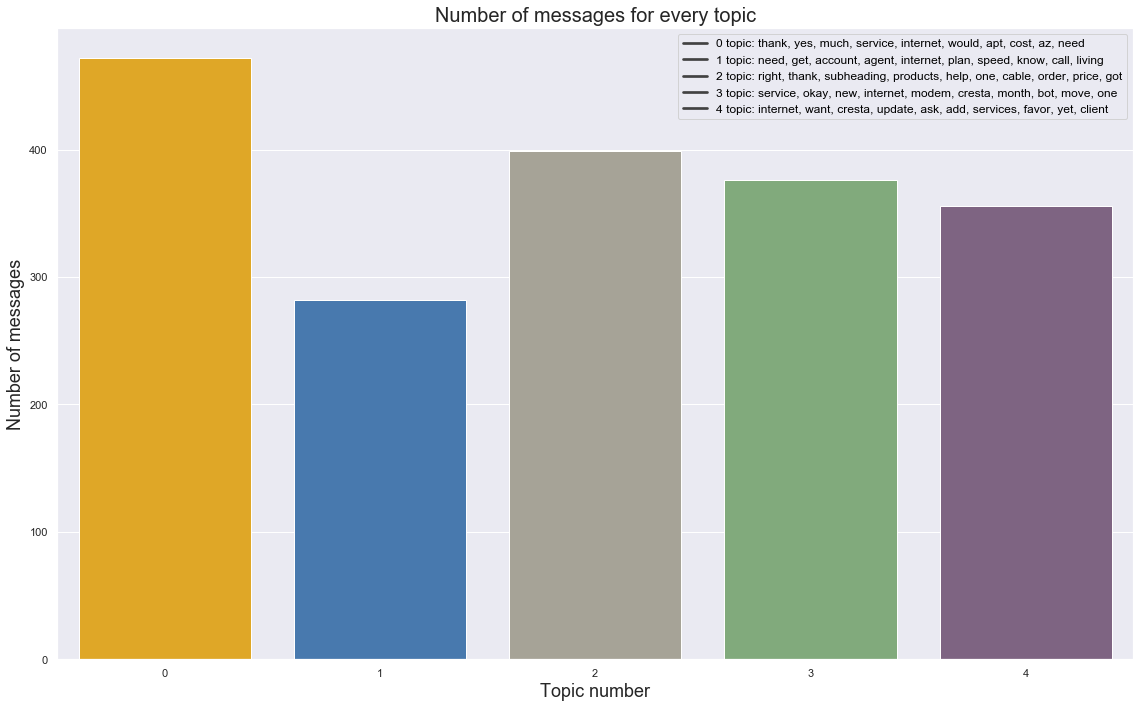

In [907]:
sns.set(style="darkgrid")
colors = ["amber", "windows blue", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

plt.figure(figsize=(16,10))

sns.barplot(x='topic',y='text',data=byTopic)
plt.title('Number of messages for every topic',fontsize=20)
legend = plt.legend(topic, prop={'size': 12}, loc='best')
plt.setp(legend.get_texts(), color='black')
plt.xlabel('Topic number', fontsize=18)
plt.ylabel('Number of messages',fontsize=18);
plt.tight_layout();
plt.savefig('oo.pdf', format='pdf', dpi=1200);

### What types of products are customers trying to buy or upgrade?

In [838]:
print('Most common words', Counter(' '.join(client_df['text'].values).split()).most_common(100), '\n')


Most common words [('right', 165), ('internet', 162), ('thank', 120), ('service', 102), ('want', 96), ('cresta', 95), ('need', 92), ('modem', 73), ('yes', 61), ('new', 58), ('ask', 55), ('account', 54), ('one', 53), ('update', 52), ('services', 51), ('get', 51), ('plan', 48), ('would', 46), ('okay', 42), ('month', 42), ('know', 40), ('cable', 40), ('help', 38), ('ca', 38), ('add', 38), ('tv', 37), ('agent', 36), ('much', 34), ('think', 32), ('see', 32), ('looking', 32), ('move', 31), ('favor', 30), ('thanks', 30), ('bot', 29), ('number', 29), ('going', 29), ('speed', 29), ('client', 28), ('yet', 28), ('please', 28), ('time', 28), ('address', 28), ('e', 28), ('order', 26), ('living', 25), ('cost', 25), ('name', 24), ('said', 24), ('could', 23), ('work', 23), ('package', 23), ('connection', 22), ('c', 22), ('go', 21), ('two', 21), ('products', 21), ('still', 21), ('subheading', 21), ('last', 20), ('already', 20), ('moved', 20), ('house', 20), ('devices', 20), ('problem', 20), ('question'

### How often are sales made in the dataset? Is it consistent across different products? (hint: look for messages indicating a confirmation of the sale)


In [472]:
agent_df = new_df[new_df['speaker_role'] == 'agent']
ag_df = agent_df.groupby('chat_number', as_index=False).agg({'text' : ' '.join})  


In [473]:
ag_df['text'] = ag_df['text'].apply(lambda x: tokenize_me(x))
ag_df['text'] = ag_df['text'].map(punc_lower)
ag_df['text']  = ag_df['text'].apply(lambda x: normalise_string(x))
ag_df['text']  = ag_df['text'].apply(lambda x: filter_string(x))


In [487]:
print('Most common words', Counter(' '.join(ag_df['text'].values).split()).most_common(100), '\n')


Most common words [('i', 1362), ('order', 384), ('help', 369), ('m', 347), ('cresta', 287), ('services', 252), ('service', 222), ('account', 220), ('please', 217), ('need', 215), ('today', 200), ('internet', 199), ('you', 168), ('thank', 161), ('modem', 156), ('chat', 153), ('name', 145), ('moment', 144), ('new', 136), ('update', 133), ('add', 131), ('number', 130), ('see', 121), ('would', 116), ('n', 116), ('address', 115), ('get', 114), ('s', 114), ('t', 114), ('agent', 110), ('how', 108), ('looking', 107), ('live', 107), ('want', 104), ('click', 104), ('the', 102), ('information', 102), ('find', 101), ('give', 99), ('installation', 96), ('right', 96), ('xxx', 95), ('what', 94), ('happy', 92), ('let', 90), ('sales', 89), ('welcome', 87), ('do', 87), ('understand', 84), ('make', 83), ('it', 82), ('free', 81), ('hello', 80), ('check', 80), ('know', 79), ('month', 76), ('support', 76), ('provide', 75), ('ask', 73), ('this', 73), ('customer', 72), ('connect', 72), ('link', 72), ('us', 71

In [846]:
n_sales = ag_df[ag_df['text'].str.contains(r'^(?=.*confirmation)(?=.*number)')]['text'].count()
print(f'Number of sales {n_sales}')

Number of sales 28


### When a sale is made, are there any trends from the agent messages leading up to the sale?


In [855]:
sales_df = ag_df[ag_df['text'].str.contains(r'^(?=.*confirmation)(?=.*number)')]

In [856]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 97
Data columns (total 2 columns):
chat_number    28 non-null object
text           28 non-null object
dtypes: object(2)
memory usage: 672.0+ bytes


In [861]:
sales_df['text'] = sales_df['text'].apply(lambda x: tokenize_me(x))
sales_df['text'] = sales_df['text'].map(punc_lower)
sales_df['text']  = sales_df['text'].apply(lambda x: normalise_string(x))
sales_df['text']  = sales_df['text'].apply(lambda x: filter_string(x))


In [862]:
print('Most common words', Counter(' '.join(sales_df['text'].values).split()).most_common(100), '\n')


Most common words [('order', 266), ('cresta', 117), ('help', 108), ('services', 102), ('need', 86), ('internet', 83), ('today', 81), ('service', 80), ('please', 77), ('number', 68), ('account', 58), ('installation', 55), ('confirmation', 52), ('receive', 52), ('click', 51), ('new', 50), ('would', 50), ('thank', 48), ('moment', 46), ('provide', 46), ('information', 46), ('find', 43), ('see', 43), ('update', 42), ('looking', 41), ('speed', 41), ('get', 41), ('address', 40), ('chat', 39), ('successfully', 39), ('welcome', 39), ('sent', 39), ('happy', 38), ('month', 38), ('right', 38), ('know', 37), ('modem', 37), ('indicate', 36), ('start', 36), ('questions', 36), ('make', 35), ('online', 35), ('e', 35), ('add', 34), ('name', 34), ('free', 34), ('link', 33), ('customer', 31), ('streaming', 31), ('plan', 31), ('give', 30), ('want', 30), ('let', 29), ('check', 29), ('live', 28), ('everything', 28), ('home', 28), ('tv', 28), ('agent', 27), ('email', 27), ('ask', 26), ('download', 26), ('per'

In [863]:
sales_df.text.str.count("quick").sum()

13

In [864]:
counts_s, vectorizer_s, corpus_id2word_s = get_words_by_threshold_report(sales_df['text'])


Words in the library: 903

Top 20 words:  [('order', 266), ('cresta', 117), ('help', 108), ('services', 102), ('need', 86), ('internet', 83), ('today', 81), ('service', 80), ('please', 77), ('number', 68), ('account', 58), ('installation', 55), ('confirmation', 52), ('receive', 52), ('click', 51), ('new', 50), ('would', 50), ('thank', 48), ('moment', 46), ('provide', 46)] 

Words with higher occurrence: ['order', 'cresta', 'help', 'services', 'need', 'internet', 'today', 'service', 'please', 'number', 'account', 'installation', 'receive', 'confirmation', 'click', 'new', 'would', 'thank', 'information', 'moment', 'provide', 'see', 'find', 'update', 'speed', 'get', 'looking', 'address', 'sent', 'successfully', 'chat', 'welcome', 'right', 'happy', 'month', 'know', 'modem', 'start', 'indicate', 'questions']

Words with lower occurrence:  ['10h', 'move', 'montth', 'money', 'moments', 'modify', 'modern', 'model', 'miss', 'minimum', 'minimize', 'messaging', 'menu', 'meets', 'makes', 'main', '

In [1063]:
lda_norm_s, gamma_norm_s = get_lda_model(counts_s, corpus_id2word_s, num_topics=4)

In [909]:
for i in range(4,8):
    lda_norm_s, gamma_norm_s = get_lda_model(counts_s, corpus_id2word_s, num_topics=i)

ELBO = -40245.9902, time: 3 seconds
ELBO = -40332.0253, time: 3 seconds
ELBO = -40569.5787, time: 3 seconds
ELBO = -40766.9293, time: 3 seconds


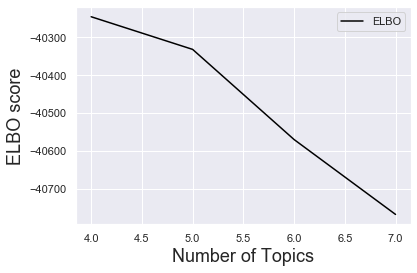

In [1064]:
plt.plot([4,5,6,7],[-40245.9902,-40332.0253,-40569.5787,-40766.9293], label='ELBO',color='black')
plt.legend()
_ = plt.ylim()
plt.ylabel('ELBO score',fontsize=18);
plt.xlabel('Number of Topics',fontsize=18);
plt.savefig('lo.pdf', format='pdf', dpi=1200);

In [913]:
build_topic_words_report(lda_norm_s, top_words_num=10)

0 topic: tv, pak, available, channels, movie, see, confirmation, channel, premium, minutes
1 topic: order, cresta, services, internet, need, please, help, today, service, receive
2 topic: order, account, help, number, name, update, see, today, service, cresta
3 topic: help, plan, internet, order, month, provide, need, looking, service, account


In [875]:
sales_topic_dynamic = pd.DataFrame(sales_df['text'])
sales_topic_dynamic['topic'] = np.argmax(gamma_norm_s, axis=1)
sales_topic_dynamic['message_count'] = sales_df['text'].apply(len)
sales_topic_dynamic.head()

,text,topic,message_count
0,okay quick question clarify need looking yet c...,1,641
1,hello name ben may ask talking today hello cha...,2,839
2,okay quick question clarify need looking yet c...,1,2614
3,glad part cresta family see looking upgrade tv...,0,1373
4,give moment find live agent welcome sales chat...,1,1943


In [908]:
sales_topic_dynamic['topic'].value_counts()

1    19
2     5
3     2
0     2
Name: topic, dtype: int64

In [870]:
bySalesTopic = sales_topic_dynamic.groupby(['topic'])['text'].count().sort_values(ascending=True).reset_index()

In [876]:
sales_topic = ['0 topic: tv, pak, available, channels, movie, see, confirmation, channel, premium, minutes',
'1 topic: order, cresta, services, internet, need, please, help, today, service, receive',
'2 topic: order, account, help, number, name, update, see, today, service, cresta',
'3 topic: help, plan, internet, order, month, provide, need, looking, service, account']

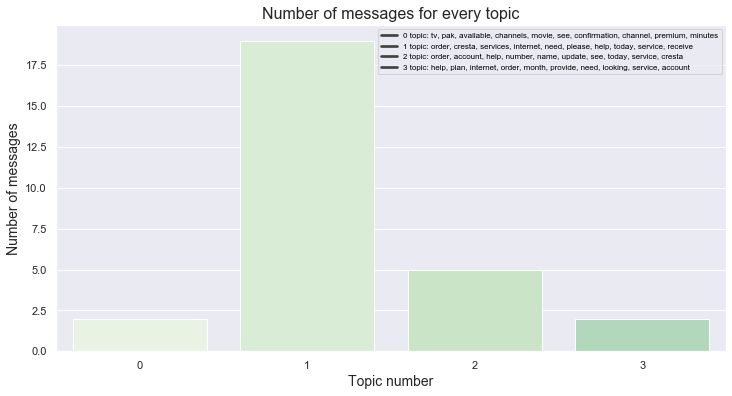

In [885]:
from matplotlib import pyplot as plt

sns.set(style="darkgrid")
colors = ["amber", "windows blue", "greyish", "faded green", "dusty purple"]
sns.set_palette("GnBu", 10)

plt.figure(figsize=(12,6))

sns.barplot(x='topic',y='text',data=bySalesTopic)
plt.title('Number of messages for every topic',fontsize=16)
legend = plt.legend(sales_topic, prop={'size': 8}, loc='best')
plt.setp(legend.get_texts(), color='black')
plt.xlabel('Topic number', fontsize=14)
plt.ylabel('Number of messages',fontsize=14)
plt.savefig('l.pdf', format='pdf', dpi=1200);


### Suprise us! What's something else interesting from the conversations that you were able to find?

In [648]:
import gensim
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

In [1000]:
# Individual datasets for every topic that can be applied to visualization 
topic_0 = sales_topic_dynamic[sales_topic_dynamic['topic'] == 0]
topic_1 = sales_topic_dynamic[sales_topic_dynamic['topic'] == 1]
topic_2 = sales_topic_dynamic[sales_topic_dynamic['topic'] == 2]
topic_3 = sales_topic_dynamic[sales_topic_dynamic['topic'] == 3]

In [1037]:
#converting text into tokens to fit Word2Vec model 
text_string = ' '.join(topic_3['text'].tolist())
text=re.sub(r"[^.A-Za-z]",' ',text_string)
sentence=text_string.split('.')
tokens=[nltk.word_tokenize(words) for words in sentence]


In [1038]:
from gensim.models import Word2Vec
model = Word2Vec(tokens, size=800)


In [1039]:
words=list(model.wv.vocab)

In [1040]:
X=model[model.wv.vocab]
df=pd.DataFrame(X)
df.shape
df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799
0,0.000553,-0.000463,0.000336,0.000324,-0.000282,-0.000104,0.000360,0.000115,0.000156,-0.000545,0.000067,0.000587,-0.000213,-0.000242,-0.000426,-0.000556,0.000232,0.000573,-0.000502,-0.000182,0.000195,0.000298,-0.000297,-0.000267,-0.000576,0.000620,-0.000448,0.000596,-0.000406,0.000132,0.000186,-0.000504,0.000568,-0.000215,0.000272,-0.000098,0.000222,-0.000219,-0.000111,0.000345,-0.000370,-0.000546,-0.000075,0.000179,3.484455e-07,0.000496,-0.000369,-0.000342,0.000610,0.000001,0.000258,-0.000630,0.000198,-0.000369,0.000516,-0.000229,-0.000453,0.000117,-0.000530,0.000117,0.000295,-0.000125,0.000545,0.000398,0.000562,0.000234,0.000505,-0.000058,-0.000055,-0.000286,-0.000148,-0.000506,-0.000023,-0.000157,0.000240,-0.000313,-0.000442,0.000153,-0.000032,0.000268,0.000225,-0.000601,-0.000422,0.000269,-0.000485,-0.000263,0.000473,0.000539,0.000458,0.000053,0.000228,0.000099,0.000364,-0.000654,-0.000410,-0.000073,-0.000354,-0.000597,0.000380,0.000507,-0.000113,-0.000625,0.000494,0.000433,-0.000219,0.000502,0.000597,-0.000173,0.000462,-0.000201,0.000138,0.000411,-0.000017,0.000018,-0.000262,0.000158,-0.000289,0.000430,-0.000204,-0.000443,-0.000297,0.000049,0.000607,0.000648,-0.000365,0.000239,0.000423,0.000074,0.000445,-0.000367,-0.000096,-0.000072,0.000233,-0.000004,-0.000587,-0.000322,-0.000386,0.000015,-0.000338,1.868201e-05,0.000236,0.000379,-0.000507,-0.000141,-0.000240,0.000335,-0.000208,-0.000357,-0.000384,-0.000302,0.000484,0.000049,0.000241,0.000554,0.000081,-0.000180,-0.000172,0.000482,0.000129,0.000561,0.000294,-0.000345,0.000517,0.000370,0.000466,-0.000241,0.000113,-0.000254,-0.000331,0.000436,0.000519,0.000142,-0.000435,0.000139,0.000186,0.000622,0.000226,0.000448,0.000014,-0.000482,-0.000528,0.000591,-0.000306,-0.000178,-0.000095,0.000138,-0.000122,-0.000437,0.000544,0.000215,0.000184,-0.000538,-0.000245,0.000596,0.000438,-0.000260,-0.000511,-0.000582,0.000410,-0.000006,-0.000504,-0.000351,-0.000262,-0.000454,0.000342,0.000299,-0.000262,0.000272,0.000504,0.000483,0.000300,-0.000069,0.000026,0.000244,-0.000037,0.000563,0.000606,-0.000358,0.000108,0.000459,-0.000323,

In [1041]:
X_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)

### Visualizing words in topics

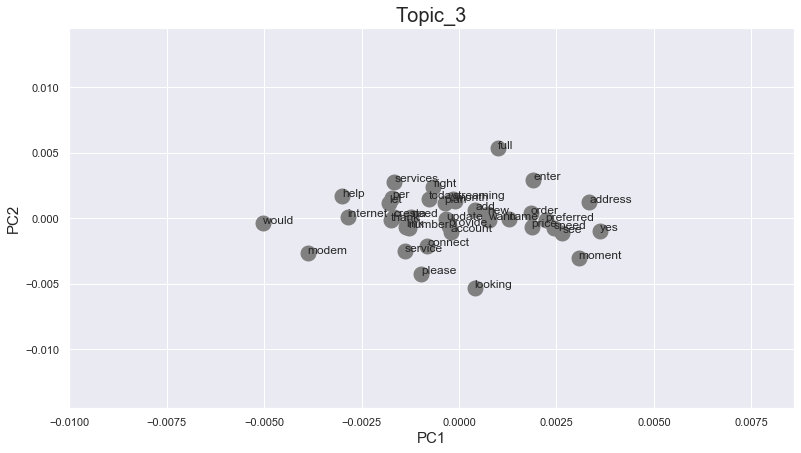

In [1042]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13,7))
plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=10,color='grey')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Topic_3",size=20)
vocab=list(model.wv.vocab)
for i, word in enumerate(vocab):
    plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))

plt.savefig('expl1.pdf', format='pdf', dpi=1200)
